# 掃Gate量IV 

In [1]:
import numpy as np
import pandas as pd
import pyvisa as visa
import matplotlib.pyplot as plt
import os, time, threading, datetime, pymeasure,tqdm
from tqdm import trange,tqdm
from time import sleep
from datetime import date
from IPython import display
from scipy.optimize import curve_fit
from pymeasure.adapters import VISAAdapter
from pathlib import Path
from pymeasure.instruments.keithley import Keithley2400, Keithley2000
import qcodes.instrument_drivers.oxford.MercuryiPS_VISA as mercury_ips
current_work_directory = os.getcwd()
os.chdir('C:/Users/USER/Device_Library/Device_Library/')
from my_SR830 import my_SR830
from my_K213 import my_K213
import device_query
os.chdir(current_work_directory)
now = datetime.datetime.now()
# print(now.strftime("%Y-%m-%d %H:%M:%S"))

C:\Users\USER\Anaconda3\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


In [2]:
visa.ResourceManager().list_resources()

('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::5::INSTR',
 'GPIB0::11::INSTR',
 'GPIB0::18::INSTR',
 'GPIB0::23::INSTR')

In [3]:
########for packed program#######
def GOTO_THREAD(K213, step, delay_time, port_id, target, time_shift):
    print("Port ID = %d , target = %.4f ."%(port_id, target))
    time.sleep(time_shift)
#     K213.GOTO(target, step, delay_time, reset_range=True,auto_range=True, reset_port=True, port=port_id)  old syntax!!
    K213.GOTO(target, step, delay_time, port = port_id, reset_range=True,auto_range=True)
    K213.GET_OUTPUT(port_id)
    time.sleep(1)
    
def TO_ZERO_THREAD(K213, step, delay_time, port_id, time_shift):
    print("Port ID = %d , target = %.4f ."%(port_id, 0.0))
    time.sleep(time_shift)
    K213.ZERO(step, delay_time, port_id)
    K213.GET_OUTPUT(port_id)
    time.sleep(1)

## 讀取830和213

In [4]:
SR830_GPIB_Addr = 5
K213_GPIB_Addr = 18
srs_source = my_SR830.MY_SR830(SR830_GPIB_Addr)
K213 = my_K213.MY_KEITHLEY213(K213_GPIB_Addr, port=1)
port_list = [1,2,3,4]  #輸入要固定的port

#[2,3,4] 如果多P4需要當GATE

C:\Users\USER\Anaconda3\lib\site-packages\pyvisa\highlevel.py:3355: FutureWarning: get_instrument is deprecated and will be removed in 1.12, use open_resource instead.
  FutureWarning,


Port 1 is selected.


# core function

In [5]:
def gates(BG):
    min_V = 1.5    #initial voltage
    max_V = 3.5    #final voltage
    data_points = 400  #resolution

    gate_voltage_apply_1 = np.append(np.linspace(min_V, max_V,data_points),np.linspace(max_V, min_V,data_points)) # for 213 port 1
    gate_voltage_apply_2 = BG # for 213 port 2
    gate_voltage_apply_3 = BG # for 213 port 3
    gate_voltage_apply_4 = 3.0 # for 213 port 4


    measure_wait_time= 2  #電壓到時等一段時間穩定後再量測
    step = 0.001         #調變電壓每一步的大小
    delay_time = 0.05    #每次調變所等待的時間
    N_ave = 10 #在一個電壓職重複量測幾次
    ave_wait = 2
    #畫圖
    fontsize = 8
    drawing_resolution=10

    #分壓比例(Source Drain SR830)
    divider_ratio= 1e-5
    #放大器比例(Source Drain SR830)
    Amplifier_gain= 1e6
    repeat = 0
    folder_path = "C:/Users/USER/Sean/2020-12-05 QD same BG test/" ##儲存的地方
    file_name = 'sameDGat_%sV_repeat%s_at_%s'%(gate_voltage_apply_2, repeat,date.today())

    print('檔名會叫做 >> %s'%file_name) 

    overwrite = 'Y'
    if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
        overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
    if overwrite == 'Y':
        file_name = file_name
    else:
        file_name = '##'
        print("please create a new file")
        raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')
    #K213.ZERO(step, delay_time, port=1)
    SD_voltage_apply = 1

    srs_goto_step = 0.05
    srs_goto_delay_time=0.5
    srs_source.input_config = 'A'
    srs_source.input_grounding = 'Float'
    srs_source.frequency = 87.11 # change the lock-in frequency
    srs_source.time_constant = 3e-1 # change the lock-in time constant
    srs_source.sensitivity = 5e-5 # change the lock-in sensitivity
    srs_source.channel1 = 'X'
    srs_source.channel2 = 'Y'

    threads = []
    shift = 4e-2 #同時給兩個port會當機所以要有一個小時間差

    print("Start...")
    for i in range(len(port_list)):
        time_shift = shift*i
        threads.append(threading.Thread(target = TO_ZERO_THREAD, args = (K213, step, delay_time,port_list[i], time_shift)))
        threads[i].start()

    for i in range(len(port_list)):
        threads[i].join()

    print("Done!")
    print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
    print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
    print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
    print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')
    #srs_source.GOTO(0.004, srs_goto_step, srs_goto_delay_time) 
    srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time)       ##### SR-830設定(固定SD)

    threads = []
    target = [min_V/0.835,gate_voltage_apply_2/0.835,gate_voltage_apply_3/0.835,gate_voltage_apply_4/0.72] #分別目標值
    shift = 0.1 #port 和 port之間開始便電壓的時間間隔

    print("Start...")
    for i in range(len(port_list)):
        time_shift = shift*i
        threads.append(threading.Thread(target = GOTO_THREAD, args = (K213, step, delay_time,port_list[i],target[i],time_shift)))
        threads[i].start()
    for i in range(len(port_list)):
        threads[i].join()
    print("Done!")

    print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
    print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
    print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
    print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')
    K213.GOTO(min_V/0.835, step, delay_time, port=1,\
              reset_range=True, auto_range = True, range_m=1)
    print("Sweeping gate goes to starting value...")
    print("Initialize K213...")
    current_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
    conductance_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    plt.figure(figsize=(3,3), dpi=200)
    plt.xlim([min_V,max_V])
        #plt.xlim([0,max_I])
    start = time.time()

    print("Apply Gate voltage...")
    gate_voltage_apply_1 = gate_voltage_apply_1/0.835
    for index_V, voltage in enumerate(tqdm(gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄
            K213.GOTO(voltage, step, delay_time, port=1,\
                      reset_range=True, auto_range = True, range_m=1)
            time.sleep(measure_wait_time)
            Sum_of_current, Sum_of_conductance = 0, 0

        ####量測####
            for n in range(N_ave):
                current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
                conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
                Sum_of_current += current_measure_xx[index_V,n]
                Sum_of_conductance += conductance_measure_xx[index_V,n]
                time.sleep(ave_wait)## Lockin delay 0.5s
            current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
            conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值

        ####畫圖####
            if (index_V%drawing_resolution==0):
                display.clear_output(wait=True)

                plt.subplot(4,1, 1)
                plt.plot(gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
                plt.xlabel("$V$ (V)")
                plt.xticks(fontsize=fontsize)
                plt.ylabel("$I$ (A)")
                plt.yticks(fontsize=fontsize)

                plt.subplot(4,1, 2)
                plt.plot(gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
                plt.xlabel("$V$ (V)")
                plt.xticks(fontsize=fontsize)
                plt.ylabel("$G$ (S)")
                plt.yticks(fontsize=fontsize)
                display.display(plt.gcf())
    #             print("Current temperature is %.4f K."%triton.GET_CURRENT_TEMPERATURE(control_channel))
    time.sleep(0.01)
    print("Measurement ends.")

    display.clear_output(wait=True)

    plt.subplot(4,1, 1)
    plt.plot(gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$I$ (A)")
    plt.yticks(fontsize=fontsize)

    plt.subplot(4,1, 2)
    plt.plot(gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$G$ (S)")
    plt.yticks(fontsize=fontsize)
    display.display(plt.gcf())
    stop = time.time()
    T=(stop-start)/60
    print('這次量測花費了 %f 分鐘'%T)
    gate_voltage_apply_1 = gate_voltage_apply_1*0.835
    raw_data = np.hstack((gate_voltage_apply_1.reshape(-1,1), current_measure_xx, conductance_measure_xx))
    data = np.hstack((gate_voltage_apply_1.reshape(-1,1), current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]]))
    np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data, fmt="%.8e", \
               header='V(V)\tI(A)*%d\tI_avg\tG(S)*%d\tG_avg(S)'%(N_ave,N_ave))
    np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
               header='VAG\tId_avg_of_%s\tG_avg_of_%s\
               \n(V)\t(A)\t(S)\
               \nresolution_%s(V)\tDG1and2_at_%sVand%sV\tDG1and2_at_%sVand%sV\tfrom%sVto%sV\tmeasure_wait_time_%s\tgoto_step_%s\tdelay_time_goto_%s'\
               %(N_ave,N_ave,\
                 (max_V-min_V)/data_points,gate_voltage_apply_2,gate_voltage_apply_3,gate_voltage_apply_2,gate_voltage_apply_3,min_V,max_V,measure_wait_time,step,delay_time))


        ####歸零####
    threads = []
    shift = 4e-2 #同時給兩個port會當機所以要有一個小時間差
    print("Start...")
    for i in range(len(port_list)):
        time_shift = shift*i
        threads.append(threading.Thread(target = TO_ZERO_THREAD, args = (K213, step, delay_time,port_list[i], time_shift)))
        threads[i].start()

    for i in range(len(port_list)):
        threads[i].join()
    print("Done!")
    print('P%d is now at'%port_list[0],K213.GET_OUTPUT(port=1),'Volts')
    print('P%d is now at'%port_list[1],K213.GET_OUTPUT(port=2),'Volts')
    print('P%d is now at'%port_list[2],K213.GET_OUTPUT(port=3),'Volts')
    print('P%d is now at'%port_list[3],K213.GET_OUTPUT(port=4),'Volts')


    #"%s/I_V_G_V%s.txt" %(folder_path,file_name)
    # print (now.strftime("%Y-%m-%d %H:%M:%S"))

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


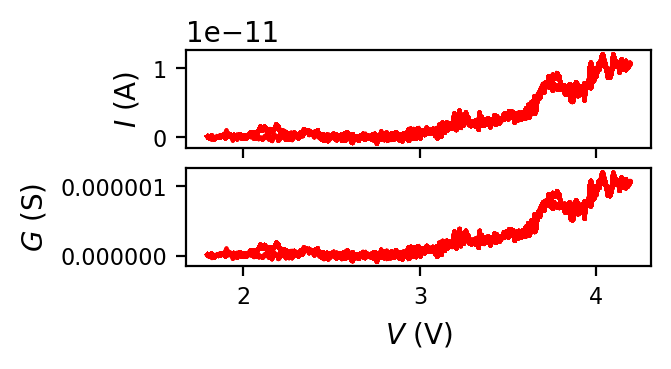

這次量測花費了 305.368925 分鐘
Start...
Port ID = 1 , target = 0.0000 .
Port ID = 2 , target = 0.0000 .Port ID = 3 , target = 0.0000 .

Port ID = 4 , target = 0.0000 .
Done!
P1 is now at 0.0 Volts
P2 is now at 0.0 Volts
P3 is now at 0.0 Volts
P4 is now at 0.0 Volts


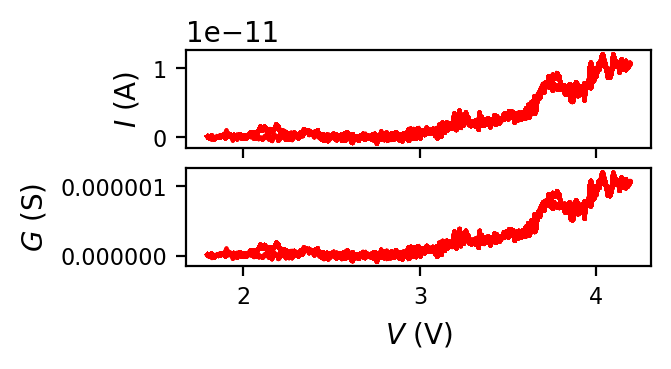

In [8]:
gates(0.2)